In [1]:
import os
import glob
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from tqdm import tqdm_notebook as tqdm
from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
import utils
from constants import DATA_DIR
warnings.filterwarnings('ignore')

Ridge Regression

In [30]:
df = pd.read_csv(os.path.join(DATA_DIR,'ABT','data.csv'))
X = df.loc[:, df.columns != 'VALUE']
y = df['VALUE']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=None)
cv = RepeatedKFold(n_splits=2, n_repeats=100)

In [31]:
model = Ridge()
parameters = {'alpha':[1, 10, 100]}
Ridge_reg= GridSearchCV(model, parameters, scoring='neg_root_mean_squared_error',cv=cv,n_jobs=-1)
#fit the grid search
Ridge_reg.fit(X_train,y_train)
# best estimator
print(Ridge_reg.best_estimator_)
# best model
best_model = Ridge_reg.best_estimator_
y_pred = best_model.predict(X_test)
print(mse(y_test, y_pred, squared=False))
print(mae(y_test, y_pred))

Ridge(alpha=10)
2.611645038970618
1.9369068323016296


Lasso Regression

In [80]:
df = pd.read_csv(os.path.join(DATA_DIR,'ABT','abt.csv'))
X = df.loc[:, df.columns != 'VALUE']
y = df['VALUE']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=None)
cv = RepeatedKFold(n_splits=2, n_repeats=1000)
#print(sum(mean) / len(mean))

In [81]:
lasso_model = Lasso()
parameters = {'alpha':[1e-2, 1e-1, 1]}
lasso_result = GridSearchCV(lasso_model, parameters, scoring='neg_root_mean_squared_error',cv=cv,n_jobs=-1)
#scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv)
lasso_result.fit(X_train, y_train)
best_model = lasso_result.best_estimator_
print(lasso_result.best_estimator_)
y_pred = best_model.predict(X_test)
print(mse(y_test, y_pred, squared=False))
print(mae(y_test, y_pred))

Lasso(alpha=0.01)
2.5035423679337576
1.8832946740462557


vanilla XGBoost Regression

In [82]:
xg_reg = XGBRegressor()

In [83]:
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)
print(mse(y_test, y_pred, squared=False))
print(mae(y_test, y_pred))

2.8693585567582893
2.292870709825912


Bayesian Opt

In [84]:
dtrain = xgb.DMatrix(X_train, label=y_train)
def bo_tune_xgb(max_depth, gamma, n_estimators ,learning_rate):
    params = {'max_depth': int(max_depth), 
              'gamma': gamma, 
              'n_estimators': int(n_estimators), 
              'learning_rate':learning_rate, 
              'subsample': 0.8, 
              'eta': 0.1, 
              'eval_metric': 'rmse'}
    cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [85]:
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (3, 10), 
                                            'gamma': (0, 1), 
                                            'learning_rate':(0,1), 
                                            'n_estimators':(100,120)
                                            })
xgb_bo.maximize(n_iter=5, init_points=8, acq='ei')


|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
[23:32:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an iss

|  4        | -2.739    |  0.8792   |  0.198    |  3.401    |  110.0    |
[23:32:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:22] WARNING: /opt/concourse/worker/vo

|  8        | -3.457    |  0.9577   |  0.7285   |  5.873    |  112.2    |
[23:32:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:26] WARNING: /opt/concourse/worker/vo

|  12       | -2.766    |  0.6959   |  0.11     |  7.941    |  101.5    |
[23:32:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:30] WARNING: /opt/concourse/worker/vo

In [86]:
params = xgb_bo.max['params']
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])
clf= XGBRegressor(**params).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(mse(y_test, y_pred, squared=False))
print(mae(y_test, y_pred))

2.7178925195930415
2.134063287517012


In [52]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn import preprocessing
from keras import regularizers
from keras.callbacks import ModelCheckpoint

import math

In [68]:
def get_modelcheckpoint_path():
    #Create a file path for a model and save models in hdf5 files with datetime, validation losses and epochs
    parent = DATA_DIR+"/NN/"
    child = pd.Timestamp.now().strftime('%Y%m%d-%Hh%Mm') + "-model-epoch_{epoch:02d}-rmse_{val_loss:.5f}.hdf5"
    return parent + child 

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(31, input_dim=31, activation='relu', 
                   kernel_initializer="he_normal", 
                   kernel_regularizer=regularizers.l2(0.000000001), 
                   activity_regularizer=regularizers.l2(0.000000001)))
    model.add(Dense(15, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

In [69]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, validation_split = 0.2,)
history = estimator.fit(X_train, y_train)
kfold = KFold(n_splits=10)
#results = cross_val_score(estimator, X_train, y_train, cv=kfold)
#mean = results.mean()
print("Baseline: %.2f (%.2f) MSE" % (math.sqrt(-1*mean), results.std()))

Epoch 1/100
130/130 [==============================] - 1s 2ms/step - loss: 14.4882 - accuracy: 0.0000e+00 - val_loss: 10.7261 - val_accuracy: 0.0000e+00
Epoch 2/100
130/130 [==============================] - 0s 1ms/step - loss: 10.6640 - accuracy: 0.0000e+00 - val_loss: 8.3714 - val_accuracy: 0.0000e+00
Epoch 3/100
130/130 [==============================] - 0s 2ms/step - loss: 9.2522 - accuracy: 0.0000e+00 - val_loss: 7.6390 - val_accuracy: 0.0000e+00
Epoch 4/100
130/130 [==============================] - 0s 2ms/step - loss: 8.5065 - accuracy: 0.0000e+00 - val_loss: 7.3145 - val_accuracy: 0.0000e+00
Epoch 5/100
130/130 [==============================] - 0s 2ms/step - loss: 8.1515 - accuracy: 0.0000e+00 - val_loss: 7.0703 - val_accuracy: 0.0000e+00
Epoch 6/100
130/130 [==============================] - 0s 1ms/step - loss: 8.0457 - accuracy: 0.0000e+00 - val_loss: 7.0733 - val_accuracy: 0.0000e+00
Epoch 7/100
130/130 [==============================] - 0s 2ms/step - loss: 7.8625 - accurac

Epoch 55/100
130/130 [==============================] - 0s 1ms/step - loss: 6.6814 - accuracy: 0.0000e+00 - val_loss: 6.4006 - val_accuracy: 0.0000e+00
Epoch 56/100
130/130 [==============================] - 0s 1ms/step - loss: 6.6777 - accuracy: 0.0000e+00 - val_loss: 6.3770 - val_accuracy: 0.0000e+00
Epoch 57/100
130/130 [==============================] - 0s 1ms/step - loss: 6.6641 - accuracy: 0.0000e+00 - val_loss: 6.3017 - val_accuracy: 0.0000e+00
Epoch 58/100
130/130 [==============================] - 0s 1ms/step - loss: 6.5798 - accuracy: 0.0000e+00 - val_loss: 6.9663 - val_accuracy: 0.0000e+00
Epoch 59/100
130/130 [==============================] - 0s 1ms/step - loss: 6.6684 - accuracy: 0.0000e+00 - val_loss: 6.5671 - val_accuracy: 0.0000e+00
Epoch 60/100
130/130 [==============================] - 0s 2ms/step - loss: 6.6088 - accuracy: 0.0000e+00 - val_loss: 6.8255 - val_accuracy: 0.0000e+00
Epoch 61/100
130/130 [==============================] - 0s 2ms/step - loss: 6.6982 - acc

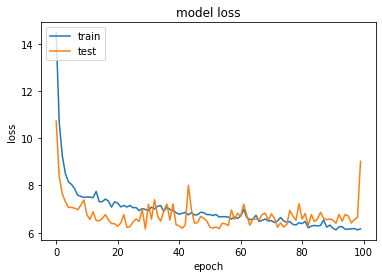

In [70]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()